this copy includes the feature, Last _ major _ derog _ none - 1 (when the loaner has a bad rating for at least 90 days), which was removed at first due to havingn large amount of missing values.

idea: What if the target labels were wrong? 

In [82]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import make_scorer, log_loss, recall_score, accuracy_score, classification_report, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, auc

In [83]:
import warnings
warnings.filterwarnings("ignore")

In [84]:
from glob import glob
glob('*')

['Predict_bad_loan.ipynb',
 'Loan_Dataset_3.csv',
 'Loan_Dataset.csv',
 'Predict_bad_loan_cont_(Unsupervised_&_Supervised_approach).ipynb',
 'Loan_Dataset_2.csv',
 'project_slides.pdf',
 'Predict_bad_loan_cont_Anomaly_Detection_questionable_data?-Copy1.ipynb',
 'bad_data.csv',
 'df_after_cleaning',
 'Predict_bad_loan_cont_(Dimensionality_Reduction_approach).ipynb',
 'Predict_bad_loan_cont_Anomaly_Detection_questionable_data?.ipynb',
 'df_cleaned.csv',
 'Predict_bad_loan_cont_Anomaly_Detection_good_data?-Copy1.ipynb',
 'Predict_bad_loan_cont_Anomaly_Detection_final_notebook.ipynb',
 'df_after_cleaning.csv',
 'Predict_bad_loan_cont_Anomaly_Detection_disregard.ipynb',
 'variable_descriptions',
 'Predict_bad_loan_cont_Anomaly_Detection_good_data?.ipynb',
 'good_data.csv']

In [85]:
df_ori = pd.read_csv('Loan_Dataset_2.csv')

In [86]:
df_ori.columns

Index(['id', 'annual_income', 'short_employee', 'emp_length_num',
       'Debt-To-Income Ratio', 'revol_util', 'total_rec_late_fee', 'od_ratio',
       'bad_loan', 'annual_income_log', 'grade_A', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_MORTGAGE',
       'home_ownership_OWN', 'home_ownership_RENT', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_small_business', 'purpose_vacation', 'purpose_wedding',
       'term_36 months', 'term_60 months', 'last_delinq_none_0',
       'last_delinq_none_1', 'last_major_derog_none_0.0',
       'last_major_derog_none_1.0', 'last_major_derog_none_missing'],
      dtype='object')

In [87]:
df = df_ori.drop(columns =['annual_income_log'])

In [88]:
def get_metrics(target_test, target_score):
    precision, recall, thresholds = precision_recall_curve(target_test, target_score)
    pr_auc = average_precision_score(target_test, target_score)
    print(f'AUC is {pr_auc:.2f}')
    return precision, recall, pr_auc

def get_confusion_matrix(target_test, target_pred):
    matrix = confusion_matrix(target_test, target_pred)
    df = pd.DataFrame(matrix, index=['Actual Negative', 'Actual Positive'], 
                 columns=['Predicted Negative', 'Predicted Positive'])
    return df

Approach 1: separate df into two datasets by target, find anomalies in each set

In [89]:
df_good_loan = df[df.bad_loan==0]
df_bad_loan = df[df.bad_loan==1]

In [90]:
#setting n_components=2 because of the assumption that some of the observations in the good loans are 
#mislabeled and should have been labeled as bad loans, and vice versa
gm_good = GaussianMixture(n_components=2, n_init=10, random_state=123)
gm_good.fit(df_good_loan)

GaussianMixture(n_components=2, n_init=10, random_state=123)

In [91]:
gm_good.weights_

array([0.10587594, 0.89412406])

In [92]:
#gm_good.means_

In [93]:
#gm.covariances_

In [94]:
gm_good.converged_, gm_good.n_iter_

(True, 8)

In [95]:
a_d = gm_good.predict(df_good_loan)
df_good_loan.shape

(14687, 38)

In [19]:
df_good_loan.loc[:,'anomaly'] = (a_d+1)%2 #now 1 represents an anomaly tag
df_good_loan['annual_income_log'] = df_good_loan.annual_income.apply(lambda x: np.log(x+1))

In [20]:
df_good_loan[df_good_loan['anomaly']==0].describe()

,id,annual_income,short_employee,emp_length_num,Debt-To-Income Ratio,revol_util,total_rec_late_fee,od_ratio,bad_loan,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months,last_delinq_none_0,last_delinq_none_1,last_major_derog_none_0.0,last_major_derog_none_1.0,last_major_derog_none_missing,anomaly,annual_income_log
count,1.313200e+04,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.0,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.0,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.0,13132.0,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.0,13132.000000
mean,7.645510e+06,74842.697837,0.106610,6.935958,16.150591,54.718180,0.001142,0.505415,0.0,0.132196,0.348690,0.287770,0.161285,0.068611,0.001066,0.000381,0.558788,0.086354,0.354858,0.009671,0.231039,0.647274,0.057645,0.0,0.000076,0.009595,0.000076,0.044548,0.000076,0.0,0.0,0.800792,0.199208,0.461620,0.538380,0.007615,0.000381,0.992004,0.0,11.100994
std,1.624422e+06,46165.237069,0.308628,3.749111,7.420002,23.107588,0.130896,0.287649,0.0,0.338717,0.476574,0.452741,0.367808,0.252801,0.032635,0.019510,0.496551,0.280897,0.478489,0.097868,0.421513,0.477837,0.233081,0.0,0.008726,0.097486,0.008726,0.206316,0.008726,0.0,0.0,0.399420,0.399420,0.498544,0.498544,0.086934,0.019510,0.089064,0.0,0.477687
min,5.860400e+05,8412.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000300,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,9.037533
25%,6.254874e+06,49500.000000,0.000000,4.000000,10.597500,38.000000,0.000000,0.257930,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,10.809748
50%,7.445298e+06,65000.000000,0.000000,7.000000,15.705000,55.900000,0.000000,0.505866,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,11.082158
75%,8.864856e+06,90000.000000,0.000000,11.000000,21.340000,72.400000,0.000000,0.753782,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.0,11.407576
max,1.145464e+07,1000000.000000,1.000000,11.000000,34.990000,107.700000,15.000000,0.999890,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,13.815512


In [21]:
df_good_loan[df_good_loan['anomaly']==1].describe()

,id,annual_income,short_employee,emp_length_num,Debt-To-Income Ratio,revol_util,total_rec_late_fee,od_ratio,bad_loan,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months,last_delinq_none_0,last_delinq_none_1,last_major_derog_none_0.0,last_major_derog_none_1.0,last_major_derog_none_missing,anomaly,annual_income_log
count,1.555000e+03,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.0,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.0,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.0,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.0,1555.000000,1555.000000,1555.0,1555.000000
mean,7.437819e+06,81675.779421,0.102251,6.666238,15.207421,53.222919,0.865105,0.504428,0.0,0.080386,0.161415,0.175563,0.146624,0.077170,0.302251,0.056592,0.473312,0.097749,0.428939,0.0,0.089389,0.335048,0.039228,0.050804,0.170418,0.0,0.055305,0.066881,0.104823,0.048232,0.039871,0.587138,0.412862,0.432797,0.567203,0.0,0.201929,0.798071,1.0,11.177567
std,1.548748e+06,47753.404068,0.303075,3.707603,7.908449,27.034724,4.798559,0.289148,0.0,0.271977,0.368031,0.380570,0.353844,0.266948,0.459381,0.231135,0.499448,0.297071,0.495084,0.0,0.285396,0.472159,0.194200,0.219668,0.376121,0.0,0.228649,0.249896,0.306424,0.214324,0.195720,0.492507,0.492507,0.495623,0.495623,0.0,0.401569,0.401569,0.0,0.507804
min,6.948910e+05,12000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000217,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,9.392745
25%,6.175502e+06,50000.000000,0.000000,3.000000,9.070000,32.750000,0.000000,0.251560,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.0,10.819798
50%,7.144638e+06,71000.000000,0.000000,7.000000,14.940000,55.500000,0.000000,0.516080,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,1.0,11.170449
75%,8.607846e+06,100000.000000,0.000000,11.000000,20.905000,75.600000,0.000000,0.750973,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.000000,1.000000,1.0,11.512935
max,1.133583e+07,500000.000000,1.000000,11.000000,34.990000,103.500000,49.550000,0.996437,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.0,13.122365


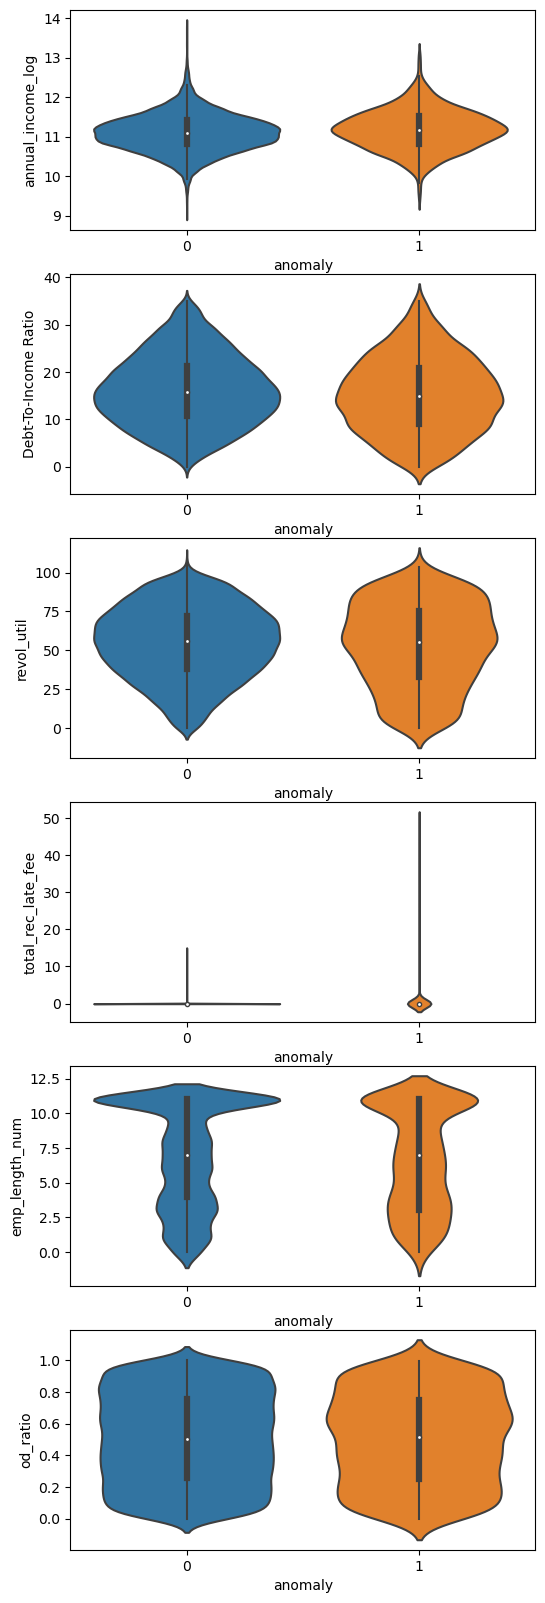

In [22]:
fig,ax = plt.subplots(6,1,figsize=(6,20))

sns.violinplot(y='annual_income_log',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[0]);

sns.violinplot(y='Debt-To-Income Ratio',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[1]);

sns.violinplot(y='revol_util',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[2]);

sns.violinplot(y='total_rec_late_fee',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[3]);

sns.violinplot(y='emp_length_num',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[4]);

sns.violinplot(y='od_ratio',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[5]);

In [23]:
ind = df_good_loan.index

In [24]:
df_no_dummy = pd.read_csv('Loan_Dataset_3.csv')
df_no_dummy.iloc[8,:]

id                         9767996
grade                            G
annual_income                60000
short_employee                   0
emp_length_num                  11
home_ownership            MORTGAGE
Debt-To-Income Ratio         26.27
purpose                    medical
term                     60 months
last_delinq_none                 0
last_major_derog_none      missing
revol_util                    94.1
total_rec_late_fee             0.0
od_ratio                  0.674835
bad_loan                         0
annual_income_log        11.002117
Name: 8, dtype: object

In [25]:
df_good_loan_2 = df_good_loan.copy() #df_____2 is for graphs
df_good_loan_2

,id,annual_income,short_employee,emp_length_num,Debt-To-Income Ratio,revol_util,total_rec_late_fee,od_ratio,bad_loan,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months,last_delinq_none_0,last_delinq_none_1,last_major_derog_none_0.0,last_major_derog_none_1.0,last_major_derog_none_missing,anomaly,annual_income_log
0,11454641,100000,1,1,26.27,43.2,0.0,0.160624,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,11.512935
1,9604874,83000,0,4,5.39,21.5,0.0,0.810777,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,11.326608
4,9795013,65000,0,11,11.26,15.2,0.0,0.166500,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,11.082158
7,7450630,96000,1,1,6.41,55.9,0.0,0.238576,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,11.472114
8,9767996,60000,0,11,26.27,94.1,0.0,0.674835,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,11.002117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18364,6615725,55000,0,8,20.07,48.9,0.0,0.648554,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,10.915107
18366,1576331,45000,0,2,23.22,46.2,0.0,0.652200,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,10.714440
18367,6645736,104000,0,5,13.27,78.5,0.0,0.482555,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,11.552156
18368,6625736,38400,0,2,12.84,47.4,0.0,0.822980,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,10.555839


In [26]:
df_no_dummy.purpose[ind]

0               credit_card
1               credit_card
4        debt_consolidation
7                     other
8                   medical
                ...        
18364    debt_consolidation
18366        major_purchase
18367    debt_consolidation
18368    debt_consolidation
18369           credit_card
Name: purpose, Length: 14687, dtype: object

In [29]:
df_good_loan_2['purpose'] = df_no_dummy.purpose[ind]
df_good_loan_2['grade'] = df_no_dummy.grade[ind]
df_good_loan_2['home_ownership'] = df_no_dummy.home_ownership[ind]
df_good_loan_2['term'] = df_no_dummy.term[ind]
df_good_loan_2['last_delinq_none'] = df_no_dummy.last_delinq_none[ind]
df_good_loan_2['last_major_derog_none'] = df_no_dummy.last_major_derog_none[ind]

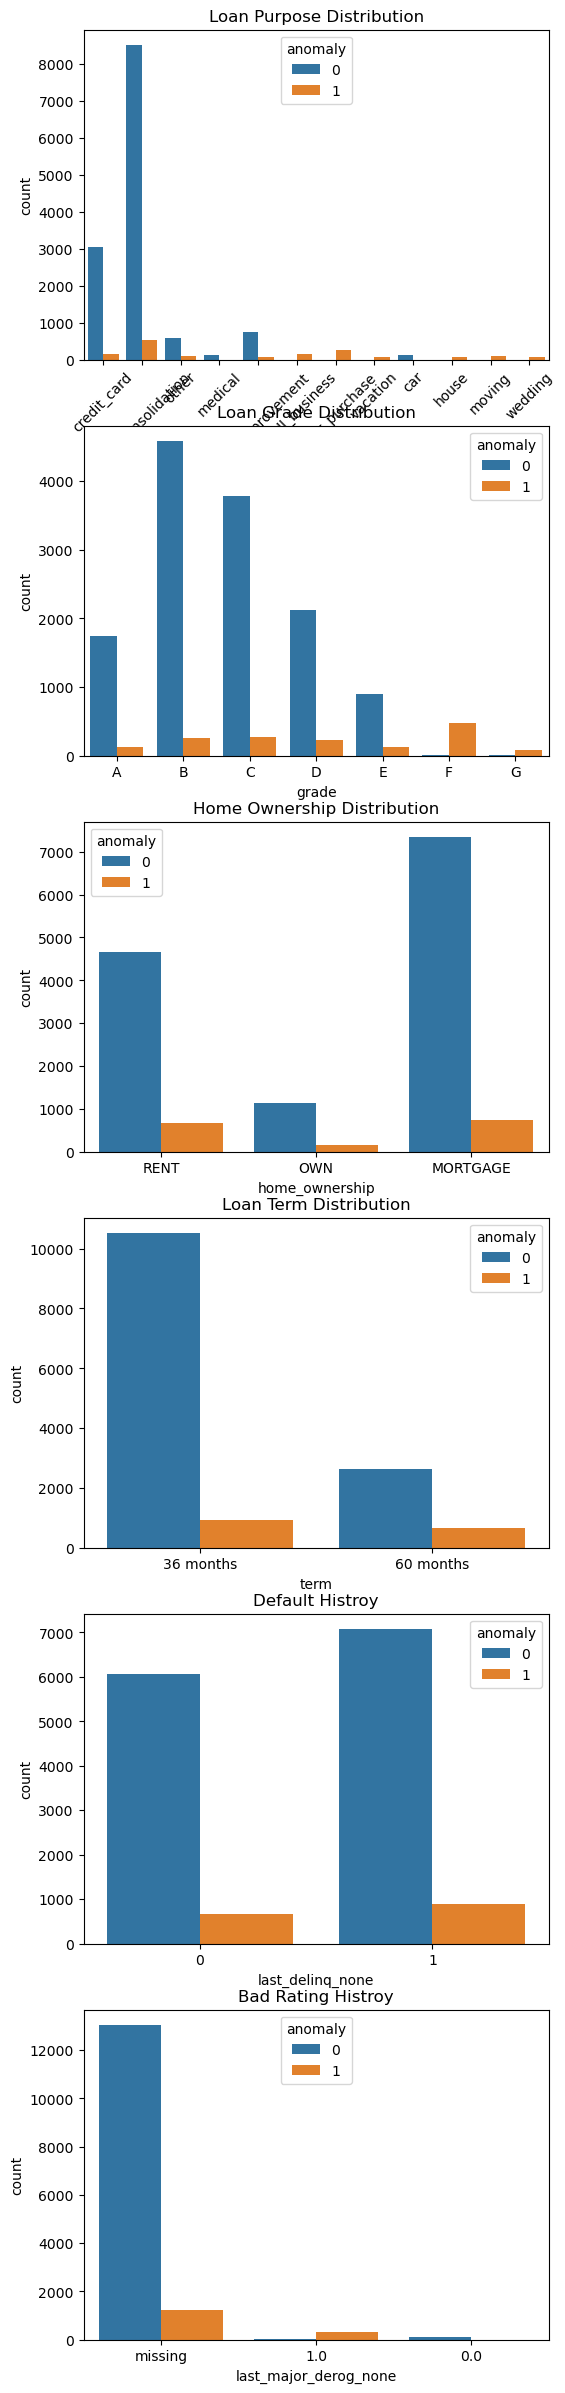

In [30]:
fig,ax = plt.subplots(6,1,figsize=(6,30))
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

sns.countplot(x=df_good_loan_2.purpose, hue=df_good_loan_2.anomaly, ax=ax[0]);
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].set_title('Loan Purpose Distribution');

sns.countplot(x=df_good_loan_2.grade, hue=df_good_loan_2.anomaly, order=grade_order, ax=ax[1]);
ax[1].set_title('Loan Grade Distribution');

sns.countplot(x=df_good_loan_2.home_ownership, hue=df_good_loan_2.anomaly, ax=ax[2]);
ax[2].set_title('Home Ownership Distribution');

sns.countplot(x=df_good_loan_2.term, hue=df_good_loan_2.anomaly, ax=ax[3]);
ax[3].set_title('Loan Term Distribution');

sns.countplot(x=df_good_loan_2.last_delinq_none, hue=df_good_loan_2.anomaly, ax=ax[4]);
ax[4].set_title('Default Histroy');

sns.countplot(x=df_good_loan_2.last_major_derog_none, hue=df_good_loan_2.anomaly, ax=ax[5]);
ax[5].set_title('Bad Rating Histroy');

In [31]:
#do the same thing for df_bad_loan
gm_bad = GaussianMixture(n_components=2, n_init=20,random_state=123)
gm_bad.fit(df_bad_loan)
gm_bad.weights_

array([0.18028863, 0.81971137])

In [32]:
gm_bad.converged_, gm_bad.n_iter_

(True, 8)

In [33]:
new_label = gm_bad.predict(df_bad_loan)

In [34]:
new_label.sum(), new_label.size

(3019, 3683)

In [35]:
#majority is bad loan. matches the assumption
new_label.mean() 

0.8197121911485202

In [36]:
df_bad_loan.loc[:,'anomaly'] = (new_label+1)%2 #now 1 represents an anomaly tag
df_bad_loan['annual_income_log'] = df_bad_loan.annual_income.apply(lambda x: np.log(x+1))

In [37]:
df_bad_loan[df_bad_loan['anomaly']==0].describe()

,id,annual_income,short_employee,emp_length_num,Debt-To-Income Ratio,revol_util,total_rec_late_fee,od_ratio,bad_loan,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months,last_delinq_none_0,last_delinq_none_1,last_major_derog_none_0.0,last_major_derog_none_1.0,last_major_derog_none_missing,anomaly,annual_income_log
count,3.019000e+03,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.0,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.0,3019.000000,3019.000000,3019.000000,3019.0,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.0,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.0,3019.000000
mean,7.534407e+06,64298.925803,0.141438,6.466380,19.074468,60.941753,0.079270,0.505742,1.0,0.038092,0.208678,0.301756,0.238821,0.126863,0.084465,0.001325,0.451143,0.081153,0.467705,0.0,0.206028,0.717125,0.003975,0.0,0.028155,0.011262,0.009275,0.000331,0.023518,0.000331,0.0,0.626698,0.373302,0.427625,0.572375,0.007618,0.022193,0.970189,0.0,10.946160
std,1.588118e+06,40347.921575,0.348530,3.853141,7.505661,21.773637,1.421622,0.288302,0.0,0.191450,0.406431,0.459096,0.426434,0.332875,0.278130,0.036382,0.497690,0.273115,0.499039,0.0,0.404518,0.450471,0.062931,0.0,0.165443,0.105541,0.095873,0.018200,0.151566,0.018200,0.0,0.483762,0.483762,0.494816,0.494816,0.086965,0.147334,0.170094,0.0,0.483040
min,1.568989e+06,10000.000000,0.000000,0.000000,0.420000,0.000000,0.000000,0.000077,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,9.210440
25%,6.177831e+06,41250.000000,0.000000,3.000000,13.460000,45.800000,0.000000,0.257257,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,10.627430
50%,7.334581e+06,55000.000000,0.000000,7.000000,19.100000,63.100000,0.000000,0.511986,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,10.915107
75%,8.649116e+06,77000.000000,0.000000,11.000000,24.685000,78.100000,0.000000,0.757583,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.0,11.251574
max,1.142457e+07,932000.000000,1.000000,11.000000,34.930000,112.900000,41.980000,0.999211,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,13.745089


In [38]:
df_bad_loan[df_bad_loan['anomaly']==1].describe()

,id,annual_income,short_employee,emp_length_num,Debt-To-Income Ratio,revol_util,total_rec_late_fee,od_ratio,bad_loan,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months,last_delinq_none_0,last_delinq_none_1,last_major_derog_none_0.0,last_major_derog_none_1.0,last_major_derog_none_missing,anomaly,annual_income_log
count,6.640000e+02,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.0,664.0,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.0,664.0,664.0,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.0,664.000000
mean,7.225588e+06,67452.724398,0.115964,6.704819,17.258072,57.974629,5.708684,0.493646,1.0,0.0,0.120482,0.250000,0.259036,0.182229,0.100904,0.087349,0.501506,0.102410,0.396084,0.042169,0.034639,0.176205,0.266566,0.021084,0.0,0.0,0.0,0.379518,0.016566,0.034639,0.028614,0.650602,0.349398,0.447289,0.552711,0.006024,0.016566,0.977410,1.0,10.971473
std,1.476610e+06,45459.323226,0.320423,3.817508,7.923902,24.241928,13.334018,0.285651,0.0,0.0,0.325770,0.433339,0.438436,0.386324,0.301428,0.282559,0.500375,0.303415,0.489451,0.201125,0.183000,0.381282,0.442497,0.143774,0.0,0.0,0.0,0.485633,0.127736,0.183000,0.166846,0.477139,0.477139,0.497589,0.497589,0.077439,0.127736,0.148706,0.0,0.528648
min,2.835604e+06,9360.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002119,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,9.144307
25%,5.969674e+06,40000.000000,0.000000,3.000000,11.052500,41.550000,0.000000,0.264960,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,10.596660
50%,6.840256e+06,59706.000000,0.000000,7.000000,17.435000,59.700000,0.000000,0.499941,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.0,10.997192
75%,8.145524e+06,80000.000000,0.000000,11.000000,23.260000,77.125000,0.000000,0.732706,1.0,0.0,0.000000,0.250000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.0,11.289794
max,1.132537e+07,550000.000000,1.000000,11.000000,34.820000,128.100000,96.466600,0.999894,1.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,13.217675


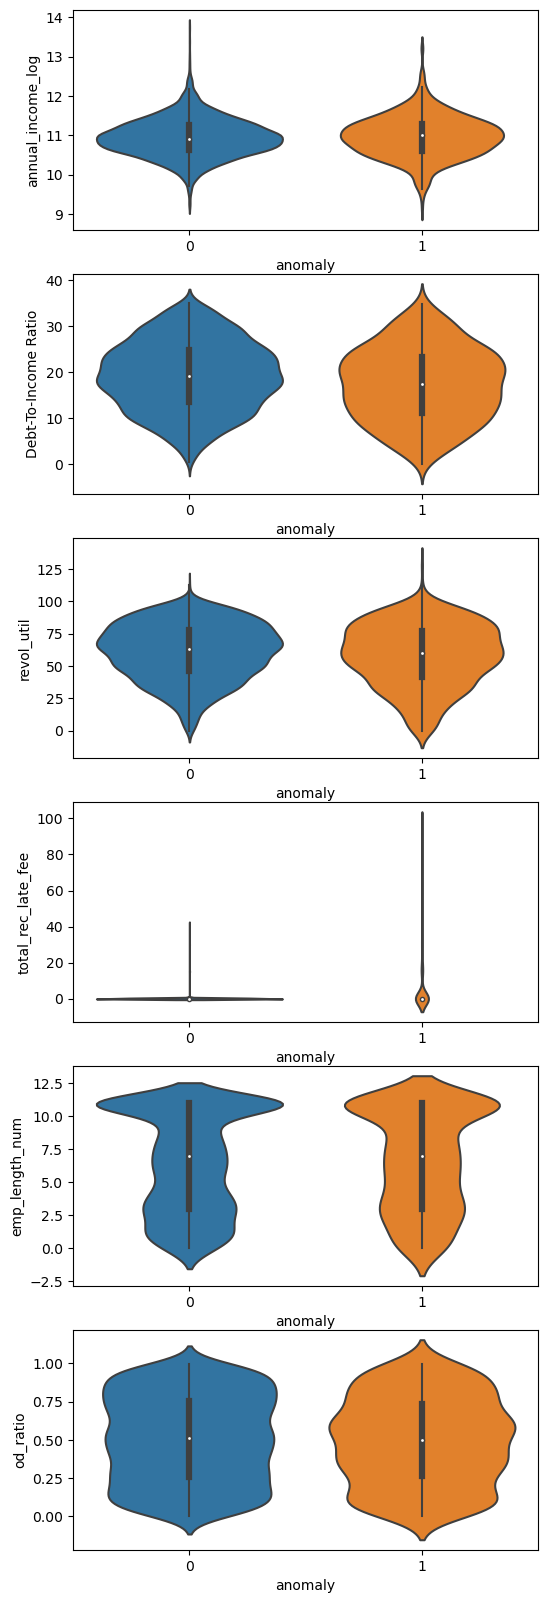

In [39]:
fig,ax = plt.subplots(6,1,figsize=(6,20))

sns.violinplot(y='annual_income_log',
                x = 'anomaly', 
                data=df_bad_loan, 
                ax=ax[0]);

sns.violinplot(y='Debt-To-Income Ratio',
                x = 'anomaly', 
                data=df_bad_loan, 
                ax=ax[1]);

sns.violinplot(y='revol_util',
                x = 'anomaly', 
                data=df_bad_loan, 
                ax=ax[2]);

sns.violinplot(y='total_rec_late_fee',
                x = 'anomaly', 
                data=df_bad_loan, 
                ax=ax[3]);

sns.violinplot(y='emp_length_num',
                x = 'anomaly', 
                data=df_bad_loan, 
                ax=ax[4]);

sns.violinplot(y='od_ratio',
                x = 'anomaly', 
                data=df_bad_loan, 
                ax=ax[5]);

In [40]:
ind_bad = df_bad_loan.index

In [41]:
df_bad_loan_2 = df_bad_loan.copy() #df_____2 is for graphs

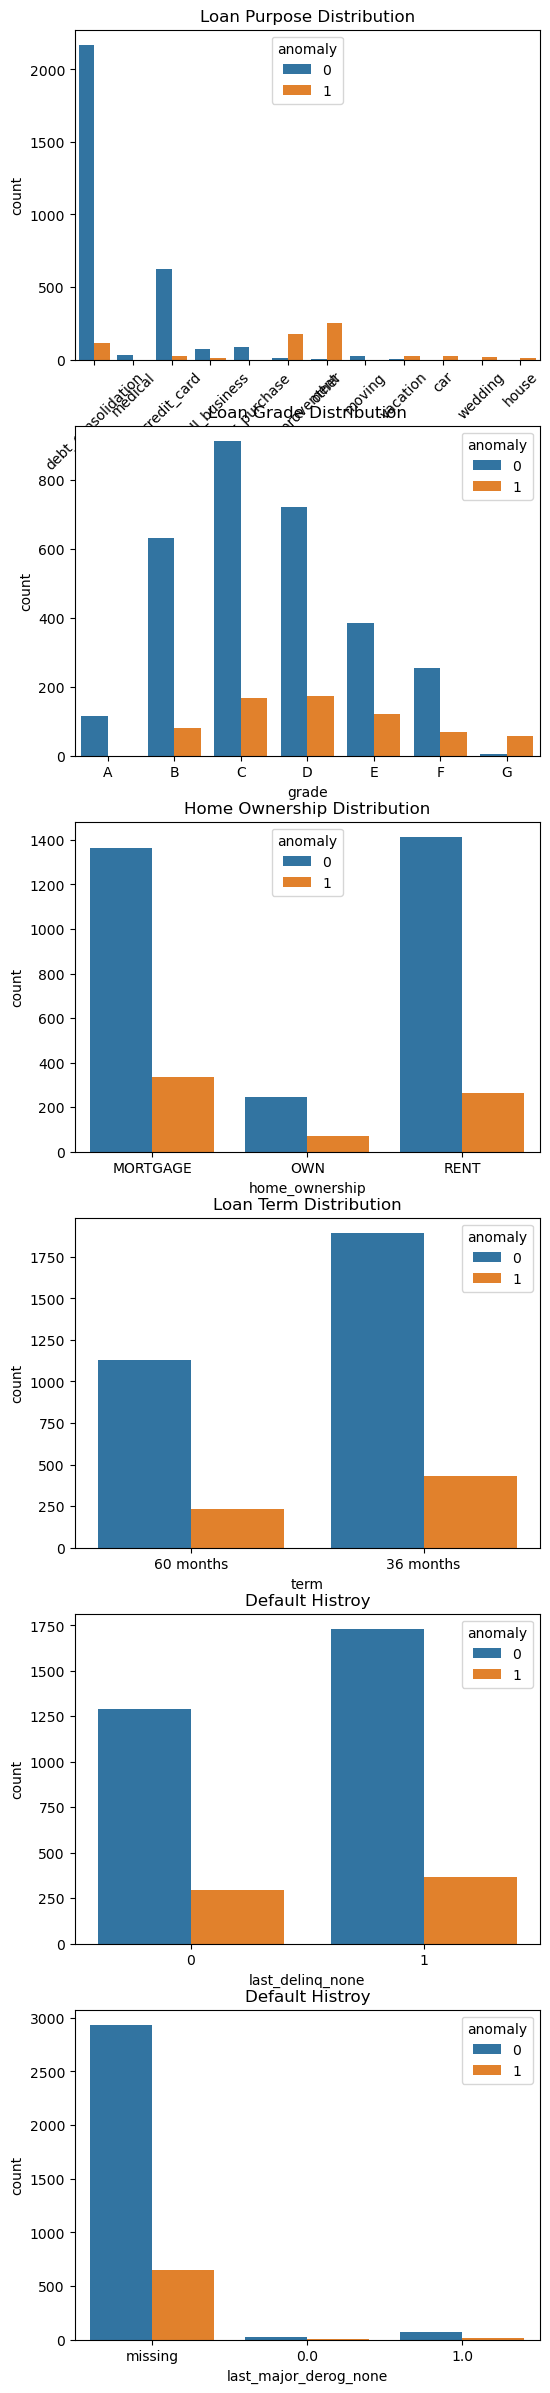

In [42]:
df_bad_loan_2['purpose'] = df_no_dummy.purpose[ind_bad]
df_bad_loan_2['grade'] = df_no_dummy.grade[ind_bad]
df_bad_loan_2['home_ownership'] = df_no_dummy.home_ownership[ind_bad]
df_bad_loan_2['term'] = df_no_dummy.term[ind_bad]
df_bad_loan_2['last_delinq_none'] = df_no_dummy.last_delinq_none[ind_bad]
df_bad_loan_2['last_major_derog_none'] = df_no_dummy.last_major_derog_none[ind_bad]

fig,ax = plt.subplots(6,1,figsize=(6,30))
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

sns.countplot(x=df_bad_loan_2.purpose, hue=df_bad_loan_2.anomaly, ax=ax[0]);
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].set_title('Loan Purpose Distribution');

sns.countplot(x=df_bad_loan_2.grade, hue=df_bad_loan_2.anomaly, order=grade_order, ax=ax[1]);
ax[1].set_title('Loan Grade Distribution');

sns.countplot(x=df_bad_loan_2.home_ownership, hue=df_bad_loan_2.anomaly, ax=ax[2]);
ax[2].set_title('Home Ownership Distribution');

sns.countplot(x=df_bad_loan_2.term, hue=df_bad_loan_2.anomaly, ax=ax[3]);
ax[3].set_title('Loan Term Distribution');

sns.countplot(x=df_bad_loan_2.last_delinq_none, hue=df_bad_loan_2.anomaly, ax=ax[4]);
ax[4].set_title('Default Histroy');

sns.countplot(x=df_bad_loan_2.last_major_derog_none, hue=df_bad_loan_2.anomaly, ax=ax[5]);
ax[5].set_title('Default Histroy');


In [43]:
df_bad_loan.anomaly.sum()

664

In [44]:
df_new = pd.concat([df_good_loan,df_bad_loan])

In [45]:
df_new.shape

(18370, 40)

In [46]:
df_norm = df_new[df_new.anomaly==0]
df_anom = df_new[df_new.anomaly==1]
df_norm.shape, df_anom.shape

((16151, 40), (2219, 40))

In [47]:
X = df_norm.drop(columns=['id', 'annual_income','bad_loan','grade_A',
                     'home_ownership_MORTGAGE','purpose_car','term_36 months',
                     'last_delinq_none_0', 'last_major_derog_none_0.0'])

y = df_norm['bad_loan'].astype(int)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=123)
train_ind, test_ind = next(sss.split(X,y,groups=None))
X_train, y_train, X_test, y_test = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

### Logistic Regression

In [49]:
param_grid = [{'C': [1, 10, 100, 1000]}]

lg_clf = LogisticRegression(class_weight='balanced',
                            random_state = 123
                           )
     
grid_search = GridSearchCV(lg_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)
               
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'C': 1}

In [50]:
lg_clf = grid_search.best_estimator_
lg_clf.fit(X_train, y_train)
y_pred = lg_clf.predict(X_test)
y_score = lg_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1848,779
Actual Positive,202,402


In [51]:
lg_precision, lg_recall, lg_pr_auc = get_metrics(y_test, y_score)

AUC is 0.51


### XGBoost

In [52]:
param_grid = [
    {'n_estimators': [94, 95, 96],
     'max_depth': [1,2, 3, 4],
     'learning_rate': [0.01, 0.1, 1]}]

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                    eval_metric='logloss',
                                    scale_pos_weight=class_weights[0]/class_weights[1],
                                    random_state = 123)

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 96}

In [53]:
xgb_classifier = grid_search.best_estimator_
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
y_score = xgb_classifier.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2627,0
Actual Positive,507,97


In [54]:
xgb_precision, xgb_recall, xgb_pr_auc = get_metrics(y_test, y_score)

AUC is 0.50


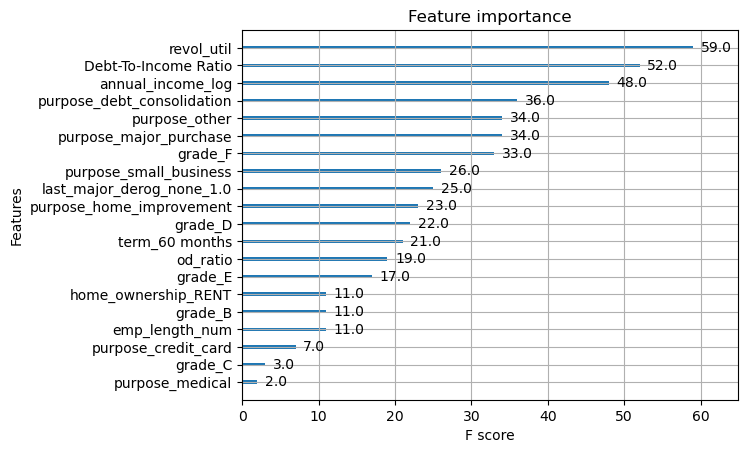

In [55]:
xgb_classifier.get_booster().feature_names =  list(X.columns)
xgb.plot_importance(xgb_classifier);

### Random Forest

In [56]:
param_grid = [
    {'n_estimators': [440, 450, 460, 470, 480],
     'max_depth': [5, 10, 15]}
]

rf_classifier = RandomForestClassifier(class_weight=class_weights,
                                       random_state = 123)

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_depth': 10, 'n_estimators': 480}

In [57]:
best_params = grid_search.best_estimator_
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
y_score = rf_classifier.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2589,38
Actual Positive,476,128


In [58]:
rf_precision, rf_recall, rf_pr_auc = get_metrics(y_test, y_score)

AUC is 0.47


In [59]:
feature_names = list(X.columns)
feature_importances = list()

for name, score in zip(feature_names, rf_classifier.feature_importances_):
    p = (name, score)
    feature_importances.append(p)

feature_importances = sorted(feature_importances, key=lambda x:x[1],reverse=True)
feature_importances

[('Debt-To-Income Ratio', 0.1770577106315029),
 ('annual_income_log', 0.16173433768341902),
 ('revol_util', 0.16047737542777576),
 ('od_ratio', 0.15211434931488563),
 ('emp_length_num', 0.08026846007590159),
 ('term_60 months', 0.028136594405806053),
 ('grade_F', 0.027474216069971996),
 ('last_delinq_none_1', 0.023972591225265377),
 ('home_ownership_RENT', 0.02069218062564042),
 ('grade_B', 0.01687370253317431),
 ('purpose_other', 0.01621330062326079),
 ('grade_D', 0.015964406576589416),
 ('purpose_debt_consolidation', 0.014875052114746923),
 ('grade_C', 0.014481250479877543),
 ('purpose_home_improvement', 0.013591540549340047),
 ('purpose_credit_card', 0.011671144284314913),
 ('home_ownership_OWN', 0.010626050470184334),
 ('grade_E', 0.010500108905403068),
 ('purpose_major_purchase', 0.010330916510780472),
 ('short_employee', 0.009399785482665991),
 ('purpose_small_business', 0.007332791802007377),
 ('last_major_derog_none_1.0', 0.005121397252188662),
 ('last_major_derog_none_missing'

#### Gradient Descent Optimization

In [60]:
param_grid = [
    {'max_iter': list(range(0, 951, 100))}
]

sgd_clf = SGDClassifier(loss='log', 
                        learning_rate='optimal',
                        tol=1e-3,
                        class_weight=class_weights,
                        random_state = 123)

grid_search = GridSearchCV(sgd_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_iter': 100}

In [61]:
sgd_clf = grid_search.best_estimator_
sgd_clf.fit(X_train, y_train)
y_pred = sgd_clf.predict(X_test)
y_score = sgd_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1824,803
Actual Positive,217,387


In [62]:
sgd_precision, sgd_recall, sgd_pr_auc = get_metrics(y_test, y_score)

AUC is 0.50


### Mini-batch Gradient Descent

In [63]:
from sklearn.base import clone

batch_size = 150
sample_size = len(X_train)

#set aside a validation batch for mini-batch SGD
sss_2 = StratifiedShuffleSplit(n_splits=1, test_size=batch_size, train_size=sample_size-batch_size)
train_ind, val_ind = next(sss_2.split(X_train, y_train))
X_train_2, y_train_2, X_mini_val, y_mini_val = X_train[list(train_ind)], y_train.iloc[train_ind], X_train[list(val_ind)], y_train.iloc[val_ind]
y_train_2 = y_train_2.to_numpy().reshape(-1,1)
combined_training_data = np.concatenate((X_train_2, y_train_2), axis = 1)

minimum_val_error = float("inf") 
best_model = None

for i in range(100):
    
    np.random.shuffle(combined_training_data)
    
    X_mini_train = combined_training_data[0:batch_size, :-1]
    y_mini_train = combined_training_data[0:batch_size, -1]
                                          
    sgd_clf.partial_fit(X_mini_train, y_mini_train, classes=np.unique(y_train_2))
    y_val_proba = sgd_clf.predict_proba(X_mini_val)
    val_error = log_loss(y_mini_val, y_val_proba)
    
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_model = clone(sgd_clf)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)


,Predicted Negative,Predicted Positive
Actual Negative,1824,803
Actual Positive,217,387


In [64]:
mbgd_precision, mbgd_recall, mbgd_pr_auc = get_metrics(y_test, y_score)

AUC is 0.50


In [65]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, log_loss, recall_score, accuracy_score, classification_report, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, auc

### Support Vector Machine

#### Linear SVM

In [66]:
param_grid = [
    {'max_iter': np.arange(2, 8, 1),
     'C': np.arange(1, 15, 1)}
]

lin_svm_clf = LinearSVC(dual=False, 
                        loss='squared_hinge',
                        random_state=123)

grid_search = GridSearchCV(lin_svm_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'C': 10, 'max_iter': 6}

In [67]:
from sklearn.calibration import CalibratedClassifierCV

lin_svm_clf = grid_search.best_estimator_
lin_svm_clf.fit(X_train, y_train)
y_pred = lin_svm_clf.predict(X_test)

clf = CalibratedClassifierCV(grid_search.best_estimator_) 
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)[:,1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2626,1
Actual Positive,499,105


In [68]:
lsvm_precision, lsvm_recall, lsvm_pr_auc = get_metrics(y_test, y_score)

AUC is 0.51


#### Polynomial Kernel Support Vector Classifier

SVC's time complexity is O(n^2 xd) to O(n^3 xd). To lower the time required to train kernel SVM models, i will use a smaller training dataset

In [69]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.8, train_size=0.2, random_state=123)
train_ind, test_ind = next(sss.split(X,y,groups=None))
X_train_2, y_train_2, X_test_2, y_test_2 = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

scaler = StandardScaler()
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)

In [70]:
param_grid = [
    {'degree': [0, 1, 2],
     'coef0': [1, 2],
     'C': [1, 10, 100]}
]

poly_kernel_svm_clf = SVC(kernel = 'poly',
                          probability = True,
                          class_weight=class_weights)

grid_search = GridSearchCV(poly_kernel_svm_clf, param_grid, cv=2,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_2, y_train_2)

grid_search.best_params_

{'C': 10, 'coef0': 2, 'degree': 1}

In [71]:
poly_kernel_svm_clf = grid_search.best_estimator_
poly_kernel_svm_clf.fit(X_train_2, y_train_2)
y_pred = poly_kernel_svm_clf.predict(X_test_2)
y_score = poly_kernel_svm_clf.predict_proba(X_test_2)[:, 1]

get_confusion_matrix(y_test_2, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,7590,2916
Actual Positive,895,1520


In [72]:
pksvm_precision, pksvm_recall, pksvm_pr_auc = get_metrics(y_test_2, y_score)

AUC is 0.48


#### Gaussian RBF Kernel Support Vector Classifier

In [73]:
param_grid = [
    {'gamma': [0.001, 0.01, 0.1, 1],
     'C': [0.1, 1, 10, 100, 1000]}
]
#https://scikit-learn.org/stable/modules/svm.html#svm-kernels
rbf_kernel_svm_clf = SVC(kernel = 'rbf',
                         probability = True,
                         class_weight=class_weights)

grid_search = GridSearchCV(rbf_kernel_svm_clf, param_grid, cv=2,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_2, y_train_2)

grid_search.best_params_

{'C': 0.1, 'gamma': 0.001}

In [74]:
rbf_kernel_svm_clf = grid_search.best_estimator_
rbf_kernel_svm_clf.fit(X_train_2, y_train_2)
y_pred = rbf_kernel_svm_clf.predict(X_test_2)
y_score = rbf_kernel_svm_clf.predict_proba(X_test_2)[:, 1]

get_confusion_matrix(y_test_2, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,10097,409
Actual Positive,1817,598


In [75]:
rbfksvm_precision, rbfksvm_recall, rbfksvm_pr_auc = get_metrics(y_test_2, y_score)

AUC is 0.48


#### Stacking/Stacked Generalization

In [76]:
base_learners = [
    ('rf', rf_classifier),
    ('sgd', sgd_clf),
    ('xgb', xgb_classifier),
]

meta_learner = LogisticRegression(class_weight=class_weights)

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
y_score = stacking_model.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1939,688
Actual Positive,230,374


In [77]:
stack_precision, stack_recall, stack_pr_auc = get_metrics(y_test, y_score)

AUC is 0.51


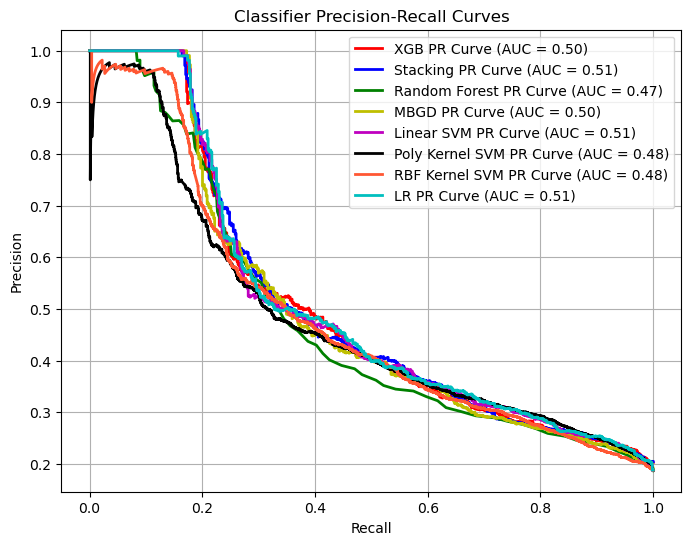

In [78]:
plt.figure(figsize=(8, 6))

plt.plot(xgb_recall, xgb_precision, color='r', lw=2, label=f'XGB PR Curve (AUC = {xgb_pr_auc:.2f})')
plt.plot(stack_recall, stack_precision, color='b', lw=2, label=f'Stacking PR Curve (AUC = {stack_pr_auc:.2f})')
plt.plot(rf_recall, rf_precision, color='g', lw=2, label=f'Random Forest PR Curve (AUC = {rf_pr_auc:.2f})')
plt.plot(mbgd_recall, mbgd_precision, color='y', lw=2, label=f'MBGD PR Curve (AUC = {mbgd_pr_auc:.2f})')
plt.plot(lsvm_recall, lsvm_precision, color='m', lw=2, label=f'Linear SVM PR Curve (AUC = {lsvm_pr_auc:.2f})')
plt.plot(pksvm_recall, pksvm_precision, color='k', lw=2, label=f'Poly Kernel SVM PR Curve (AUC = {pksvm_pr_auc:.2f})')
plt.plot(rbfksvm_recall, rbfksvm_precision, color='#FF5733', lw=2, label=f'RBF Kernel SVM PR Curve (AUC = {rbfksvm_pr_auc:.2f})')
plt.plot(lg_recall, lg_precision, color='c', lw=2, label=f'LR PR Curve (AUC = {lg_pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Classifier Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

including this feature adds 0.05 to 0.09 performance!!